In [40]:
import torch
from torchvision import datasets, transforms

# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the testing data
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Example of iterating through the data
for images, labels in train_loader:
    print(images.shape)  # Print the shape of the images (batch_size, channels, height, width)
    print(labels.shape)  # Print the shape of the labels (batch_size)
    break  # Remove this break to iterate through the entire dataset

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [29]:
from qiskit.circuit import ParameterVector
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

import torch
import torch.nn as nn
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector
from torch import optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

In [2]:
from matplotlib import pyplot as plt


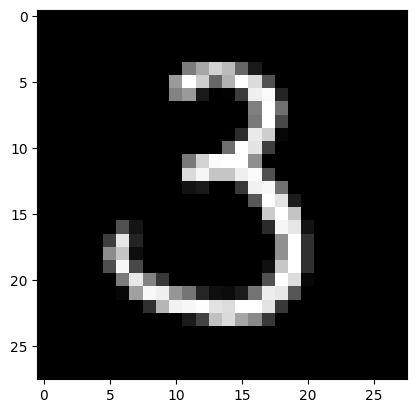

In [41]:
plt.imshow(images[0][0].numpy(), cmap='gray')

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


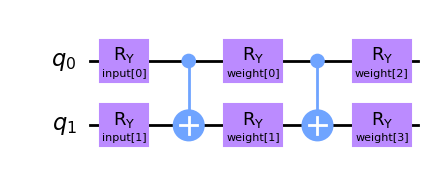

In [42]:


inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw("mpl", style="clifford")

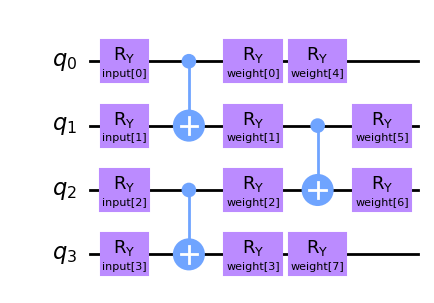

In [50]:
def create_qnn(num_qubits=2,num_layers = 1):
    """
    Create a quantum neural network layer with the specified number of qubits and parameters.
    """
    inputs = ParameterVector("input", num_qubits)
    weights = ParameterVector("weight", num_qubits * num_layers*2)
    qc2 = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc2.ry(inputs[i], i)
    weight_count = 0
    for i in range(num_layers):
        for j in range(0,num_qubits,2):
            if j+1 < num_qubits:
                qc2.cx(j, j+1)
        for j in range(num_qubits):
            qc2.ry(weights[weight_count], j)
            weight_count += 1
        for j in range(1,num_qubits,2):
            if j+1 < num_qubits:
                qc2.cx(j, j+1)
        for j in range(num_qubits):
            qc2.ry(weights[weight_count], j)
            weight_count += 1
    return qc2, inputs, weights
qc2, inputs, weights = create_qnn(num_qubits=4,num_layers = 1)
qc2.draw("mpl", style="clifford")

In [35]:
sampler = Sampler()
sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs, weight_params=weights, sampler=sampler)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights) 

torch_quantum_model = TorchConnector(sampler_qnn, sampler_qnn_weights)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [53]:
dummy_2d_tensor = torch.rand(4, 4)
print(dummy_2d_tensor.shape)
print(nn.Flatten(start_dim=0)(dummy_2d_tensor).shape)

torch.Size([4, 4])
torch.Size([16])


In [54]:

class quantum_model(nn.Module):
    def __init__(self, qnn, num_qubits=4):
        super(quantum_model, self).__init__()
        self.qnn = qnn
        self.flatten = nn.Flatten()
        self.reducer = nn.Linear(28*28, 4)  # Assuming the output of the QNN is 4-dimensional
        self.head = nn.Linear(2**num_qubits, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.reducer(x)
        x = self.qnn(x)
        x = self.head(x)
        return x

In [55]:
dummy_input = torch.randn(64, 1, 28, 28)  # Example input
model = quantum_model(qnn=torch_quantum_model, num_qubits=4)
model(dummy_input).shape  # Check the output shape

torch.Size([64, 10])

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function
learning_rate = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training parameters
epochs = 10
evaluation_steps = 100  # Evaluate every K steps
step = 0

# Training loop
for epoch in range(epochs):
    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        eyes_label = np.eye(10)
        labels = eyes_label[labels.cpu().numpy()]
        labels = torch.tensor(labels, dtype=torch.float32).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, torch.argmax(labels, dim=1)) # CrossEntropyLoss expects class indices

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1


        # Evaluation
        if step % evaluation_steps == 0:
            model.eval()
            all_preds = []
            all_labels = []
            val_loss = 0.0
            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    eyes_label = np.eye(10)
                    val_labels = eyes_label[val_labels.cpu().numpy()]
                    val_labels = torch.tensor(val_labels, dtype=torch.float32).to(device)
                    val_outputs = model(val_images)
                    val_loss += criterion(val_outputs, torch.argmax(val_labels, dim=1)).item()

                    _, predicted = torch.max(val_outputs, 1)
                    true_labels = torch.argmax(val_labels, dim=1)

                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(true_labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            accuracy = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='weighted')
            precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step}], Train Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4f}, Val F1: {f1:.4f}, Val Precision: {precision:.4f}, Val Recall: {recall:.4f}")
            model.train() # Set back to train mode

  0%|          | 0/938 [00:00<?, ?it/s]

  9%|▊         | 82/938 [06:05<1:17:19,  5.42s/it]

In [57]:
dummy_labels = [0, 1,3,5]
eyes_label = np.eye(10)
print(eyes_label[dummy_labels])


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [ ]:
print()